In [1]:
import pandas as pd
import numpy as np
from helpers import *
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display as dp
import joblib
import warnings
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats


# Filter out the specific warning by category
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_style("darkgrid")

### EDA and Feature Selection

In [2]:
acc_df = joblib.load("data/acc_prepped_df")

comp_df = joblib.load("data/comp_df")
acc_comp_df = joblib.load("data/acc_comp_df")
rej_comp_df = joblib.load("data/rej_comp_df")

comp_df = comp_df.replace(99999, np.nan)
acc_comp_df = acc_comp_df.replace(99999, np.nan)
rej_comp_df = rej_comp_df.replace(99999, np.nan)
acc_df = acc_df.replace(99999, np.nan)

##### EDA for comparison df (loan_accepted and loan_rejected)

📊 target variable

In [6]:
input_to_df(
    dict(Counter(comp_df.accepted)), is_dict=True, col_name="loan_accepted_count"
)

,loan_accepted_count
0,24597121
1,2260371


Data is imbalanced, only less than 10% of loan is accepted.

📊 Feature distribution

- loan_title

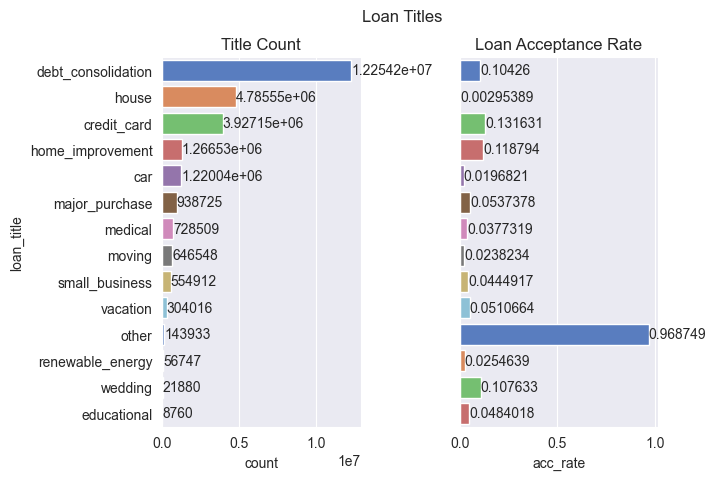

In [184]:
loan_title_stats = (
    comp_df.groupby("loan_title")
    .accepted.agg(acc_rate="mean", count="count")
    .sort_values(by="count", ascending=False)
)


loan_title_stats["loan_title"] = loan_title_stats.index

plt.suptitle("Loan Titles")
plt.subplot(1, 2, 1)
ax = sns.barplot(data=loan_title_stats, y="loan_title",
                 x="count", palette="muted")
mark_bar(ax)
plt.title("Title Count")
plt.subplot(1, 2, 2)
ax = sns.barplot(data=loan_title_stats, y="loan_title",
                 x="acc_rate", palette="muted")
mark_bar(ax)

plt.title("Loan Acceptance Rate")

plt.ylabel("")
plt.yticks([])
plt.subplots_adjust(wspace=0.5)
plt.show()

> The acceptance rate of category 'other' is exceptionally high, we would label \
it as a feature. 

In [9]:
loan_title_other = comp_df.loan_title == "other"
comp_df["loan_title_other"] = loan_title_other

📊 Except from category 'other', do different loan titles have significantly \
different loan_acceptance rate ? Verify with stats test:

H0: There is no significant difference between different loan title and loan \
acceptance rate.

Ha: There is significant difference between different loan title and loan \
acceptance rate.

alhpa = 0.05

In [32]:
loan_titles = comp_df.loan_title.unique().tolist()
loan_titles.remove("other")
title_groupped_acceptance = comp_df[["loan_title", "accepted"]].groupby("loan_title")

loan_title_acc_ls = []
for i in loan_titles:
    group_ls = title_groupped_acceptance.get_group(i).accepted.tolist()
    loan_title_acc_ls.append(group_ls)

In [36]:
# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*loan_title_acc_ls)

print("F-statistic:", f_statistic)
print("p-value:", p_value)

if p_value < 0.05:
    bprint("> There are significant differences among the loan_title accpeptance rate.")
else:
    bprint(
        "> There are no significant differences among the loan_title accpeptance rate."
    )

F-statistic: 67616.70493681151
p-value: 0.0

> There are significant differences among the loan_title accpeptance rate.


📝 Loan titles

`Debt consolidation` is the most common loan title in both loans, followed by \
house and credit card. 

Category 'other' has the highest loan acceptance rate (96%). \
When loan title cannot be easily categorized, we put it in the 'other' \
category, many of them were just the name or account name of the applicants. \
This is a very good predictor !

Debt consolidation, credit_card, home_improvement, and wedding related loans \
also have around 10% of acceptance rate.

Loan title can be a good predictor for acceptance as the acceptance rate has \
signigicant difference among them.

- amount_requested

In [11]:
bprint("Maximum loan accepted: ")
comp_df.loc[comp_df.accepted == 1].amount_requested.max()


Maximum loan accepted: 


40000.0

Add label for amount_requested > 40000, as all loans > 40000 are rejected.

In [14]:
amnt_req_big = comp_df.amount_requested > 40000
comp_df["amnt_req_big"] = amnt_req_big

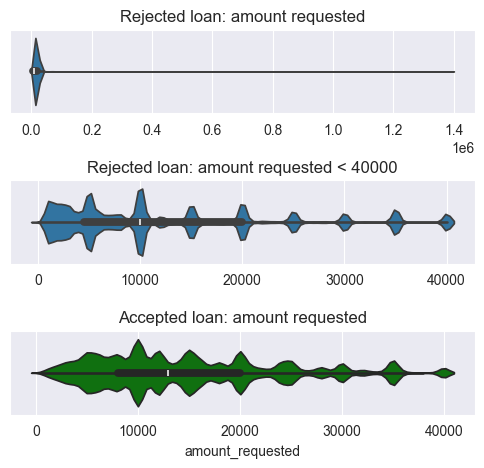

In [10]:
fig_size(6, 5)

plt.subplot(3, 1, 1)
sns.violinplot(
    data=rej_comp_df,
    x="amount_requested",
)
plt.title("Rejected loan: amount requested")
plt.xlabel("")

plt.subplot(3, 1, 2)
sns.violinplot(
    data=rej_comp_df.loc[rej_comp_df.amount_requested < 40001],
    x="amount_requested",
)
plt.title("Rejected loan: amount requested < 40000")
plt.xlabel("")

plt.subplot(3, 1, 3)
sns.violinplot(data=acc_comp_df, x="amount_requested", color="green")
plt.title("Accepted loan: amount requested")


plt.subplots_adjust(hspace=0.8)
plt.show()

📝 Compare requested amount for accepted and rejected loans. 

All accepted loan has requested amount < 40,000 dollars. 

People like to request loan amount closet to full numbers such as 10,000, 20,000, ... 

Looking at requested amount < 40,000, we can see that the median of accepted \
loan is about 2500 dollars more than rejected loan.

- risk_score

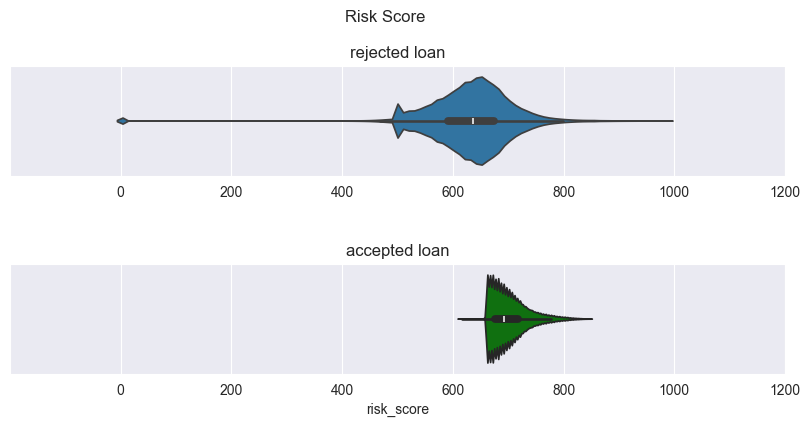

In [16]:
fig_size(10, 4)

plt.subplot(2, 1, 1)
sns.violinplot(
    data=rej_comp_df,
    x="risk_score",
)
plt.title("rejected loan")
plt.xlabel("")
plt.xticks(range(-200, 1201, 200))
plt.xticks([0, 200, 400, 600, 800, 1000, 1200])


plt.subplot(2, 1, 2)
sns.violinplot(data=acc_comp_df, x="risk_score", color="green")
plt.xticks(range(-200, 1200, 200))
plt.xticks([0, 200, 400, 600, 800, 1000, 1200])

plt.title("accepted loan")
plt.suptitle("Risk Score", y=1.02)
plt.subplots_adjust(hspace=0.8)
plt.show()

📝 Compare risk_score for accepted and rejected loans. 

Almost all accepted loan rows have score above 650, with median being approx. 685, \
while rejected loan rows have median approx. 620, and there's a small population \
with score = 0. 

- debt_to_income_ratio

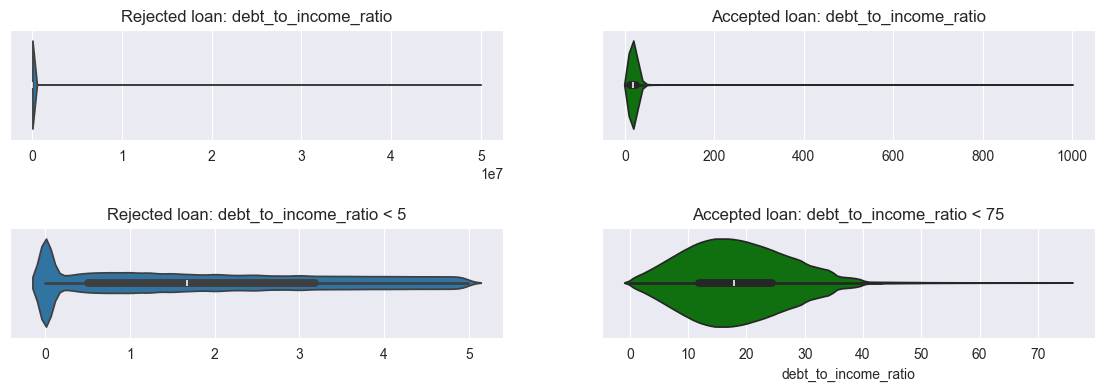

In [12]:
fig_size(14, 4)

plt.subplot(2, 2, 1)
sns.violinplot(
    data=rej_comp_df,
    x="debt_to_income_ratio",
)
plt.title("Rejected loan: debt_to_income_ratio")
plt.xlabel("")

plt.subplot(2, 2, 3)
sns.violinplot(
    data=rej_comp_df.loc[rej_comp_df.debt_to_income_ratio < 5],
    x="debt_to_income_ratio",
)
plt.title("Rejected loan: debt_to_income_ratio < 5")
plt.xlabel("")

plt.subplot(2, 2, 2)
sns.violinplot(
    data=acc_comp_df,
    x="debt_to_income_ratio",
    color="green",
)
plt.title("Accepted loan: debt_to_income_ratio")
plt.xlabel("")

plt.subplot(2, 2, 4)
sns.violinplot(
    data=acc_comp_df.loc[acc_comp_df.debt_to_income_ratio < 75],
    x="debt_to_income_ratio",
    color="green",
)
plt.title("Accepted loan: debt_to_income_ratio < 75")

plt.subplots_adjust(hspace=0.8)
plt.show()

📝 Compare debt_to_income_ratio (dti) for accepted and rejected loans. 

The full data distribution of dti for both loan_acc and loan_rej are highly \
right skewed. 

After zooming into the main distribution, we can see that the \
loan_rejected data rows have much lower dti comparing to loan_accepted, with \
the majority of the data being 0.

The distribution is not normal with many outliers, non parametric tree based \
models would be less biased.

- employment length

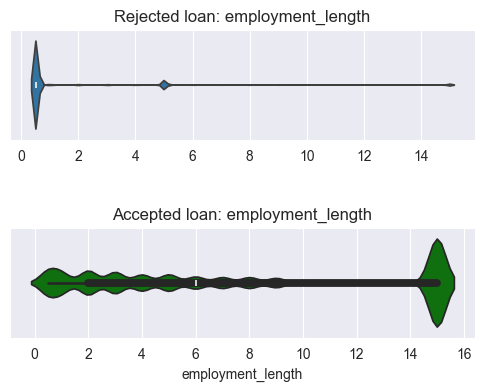

In [13]:
fig_size(6, 4)

plt.subplot(2, 1, 1)
sns.violinplot(
    data=rej_comp_df,
    x="employment_length",
)
plt.title("Rejected loan: employment_length")
plt.xlabel("")

plt.subplot(2, 1, 2)
sns.violinplot(data=acc_comp_df, x="employment_length", color="green")
plt.title("Accepted loan: employment_length")

plt.subplots_adjust(hspace=0.8)
plt.show()

📝 Employment length

The employment_length median of loan accepted applicants is 6 while 0.5 for \
loan rejected applicants. 

Majority of loan_rejected people only have employment \
length of 0.5 year (< 1 year), while a huge population of loan_accepted people \
have worked for more than 10 years.

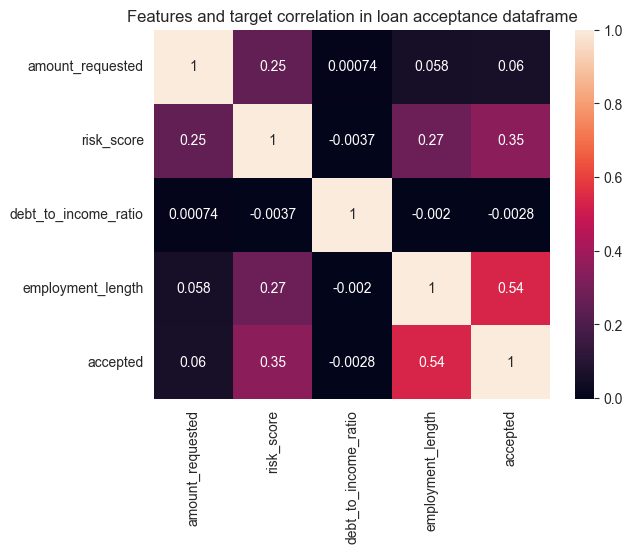

In [15]:
num_cols = comp_df.select_dtypes(["int", "float"]).columns.tolist()
sns.heatmap(comp_df[num_cols].corr(), annot=True)
plt.title("Features and target correlation in loan acceptance dataframe")
plt.show()

📝 Features and target correlation

Loan acceptance has the strongest correlation with employment_length and risk_score. 

These two features also have moderate correlation with eachother, as they both \
kind of represent a person's length and quality of credit history.


---

#### Loan_accepted dataframe

In [202]:
acc_df.head(3)

,grade,sub_grade,int_rate,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,C,C4,13.99,3600,0,123.03,15.0,MORTGAGE,55000.0,0,...,0,3,76.9,0.0,0,0,178050,7746,2400,13734
1,C,C1,11.99,24700,0,820.28,15.0,MORTGAGE,65000.0,0,...,0,2,97.4,7.7,0,0,314017,39475,79300,24667
2,B,B4,10.78,20000,1,432.66,15.0,MORTGAGE,63000.0,0,...,0,0,100.0,50.0,0,0,218418,18696,6200,14877


📊 Target variables

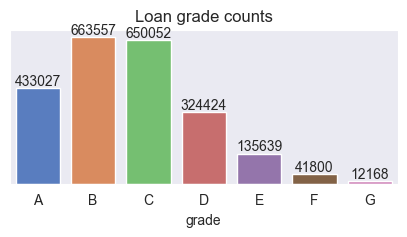

In [246]:
plt_grade = (
    input_to_df(acc_df.grade.value_counts(), col_name="count")
    .reset_index()
    .sort_values(by="index")
)
plt_grade
fig_size(5, 2)
ax = sns.barplot(data=plt_grade, x="index", y="count", palette="muted")
mark_bar(ax)
plt.title("Loan grade counts")
plt.ylabel("")
plt.yticks([])
plt.xlabel("grade")
plt.show()

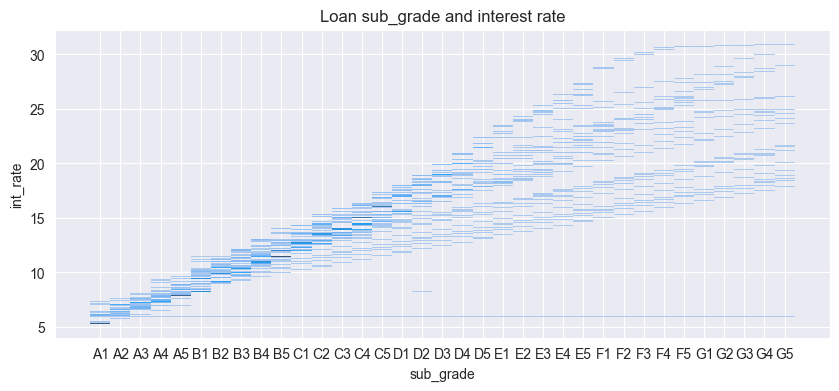

In [247]:
fig_size(10, 4)
sns.histplot(data=acc_df.sort_values(
    by="sub_grade"), x="sub_grade", y="int_rate")
plt.title("Loan sub_grade and interest rate")
plt.show()

📝 Target 

Knowing the grade would make the prediction for subgrades and interest rate of \
the A, B, C grade easier, but it would still be challenging to tell grade E, F, \
G apart as the interest rate has much bigger variation, and overlaps with other \
grades.

📊 Feature Selection

This dataframe contains around 100 features, to avoid the curse of dimensionality \
and make our modeling more efficient, we'd use `Boruta` for feature selection.

Run Boruta with 100,000 sample rows to be more efficient. 

In [20]:
feat_count = len(acc_df.columns) - 3

print(f"There are {feat_count} features in the acc_df dataframe.")

There are 98 features in the acc_df dataframe.


- Prepare data

In [21]:
acc_df_sample = acc_df.sample(100000, random_state=0)

target_map = {"A": 0.0, "B": 1.0, "C": 2.0, "D": 3.0, "E": 4.0, "F": 5.0, "G": 6.0}
sample_target = acc_df_sample.grade.apply(lambda i: target_map[i]).values
sample_features = acc_df_sample.drop(
    columns=["grade", "sub_grade", "int_rate", "zip_code"]
)

# cast types
cat_df = sample_features.select_dtypes("string")
cat_df = cat_df.astype("category")

num_df = sample_features.select_dtypes(["int", "float"])
num_df = num_df.astype("float")

sample_df = cat_df.join(num_df)

X = sample_df
y = sample_target

Preprocessing and Boruta pipeline

In [23]:
# columns
cat_cols = [
    "home_ownership",
    "purpose",
    "addr_state",
    "initial_list_status",
    "application_type",
]


num_cols = (
    acc_df.select_dtypes(["float", "int"]).drop(
        columns=["int_rate"]).columns.tolist()
)

# imputers
cat_imp = CategoricalImputer(imputation_method="frequent")
num_imp = MeanMedianImputer()

# encoders
ohe_encode = OneHotEncoder()
cfe_encode = CountFrequencyEncoder()

# preprocessing
cat_preprocess = Pipeline(
    [("cat_imputation", cat_imp), ("encode", ohe_encode)])

num_preprocess = Pipeline([("num_imputation", num_imp)])

preprocess = ColumnTransformer(
    transformers=[
        ("categorical", cat_preprocess, cat_cols),
        ("numerical", num_preprocess, num_cols),
    ],
    remainder="passthrough",
)

In [24]:
rf = RandomForestClassifier(
    max_depth=5, class_weight="balanced", n_jobs=-1, random_state=0
)

feature_selector = BorutaPy(rf, n_estimators="auto", verbose=-1, random_state=1)

boruta_pipeline = Pipeline(
    [("preprocess", preprocess), ("feature_selection", feature_selector)]
)

boruta_pipeline = joblib.load("data/boruta_grade_pipeline")

dp(boruta_pipeline)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('cat_imputation',
                                                                   CategoricalImputer(imputation_method='frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder())]),
                                                  ['home_ownership', 'purpose',
                                                   'addr_state',
                                                   'initial_list_status',
                                                   'application_type']),
                                                 ('numerical',
                                                  Pipeline(steps=[('num_imputation',
                                                                   MeanM...
                                                   'recoveries',
                                                   'collection_recovery_fee',
                                                   'last_pymnt_amnt',
                                                   'last_fico_range_high', ...])])),
                ('feature_selection',
                 BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                                           max_depth=5,
                                                           n_estimators=209,
                                                           n_jobs=-1,
                                                           random_state=RandomState(MT19937) at 0x7F9C2DB72E40),
                          n_estimators='auto',
                          random_state=RandomState(MT19937) at 0x7F9C2DB72E40,
                          verbose=-1))])

In [25]:
preprocess_cols = boruta_pipeline[0].get_feature_names_out()

feat_rank = list(zip(list(boruta_pipeline[-1].ranking_), list(preprocess_cols)))

selected_feats = [i[1].split("__")[1] for i in feat_rank if i[0] < 2]
print(f"{len(selected_feats)-2} features selected.")

feat_selected_acc_df = acc_df.loc[
    :, selected_feats[4:] + ["purpose", "initial_list_status"]
]

feat_selected_acc_df.columns

52 features selected.


Index(['loan_amnt', 'term', 'installment', 'annual_inc', 'verification_status',
       'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'tot_cur_bal', 'open_acc_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'il_util', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_tl_op_past_12m', 'percent_bc_gt_75', 'tot_hi_cred_lim',
       'total_bc_limit', 'purpose', 'initial_list_status'],


- Loan purpose and grade 

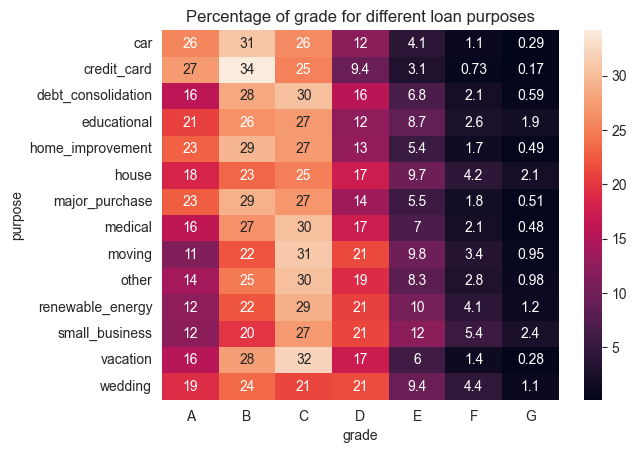

In [119]:
ct = pd.crosstab(acc_df.grade, acc_df.purpose)
ct_sum = np.array(ct.sum(axis=0).tolist())
ct_sum = np.tile(ct_sum, 7).reshape(7, 14)
sns.heatmap((ct * 100 / ct_sum).T, annot=True)

plt.title("Percentage of grade for different loan purposes")
plt.show()

📝 
Almost all loan purposes have the highest chance of receiving grade B and C. \

Although purpose 'other' has high loan acceptance rate as we've seem before, \
the loan grade is worse than most other purposes.


📊 Correlation of selected features and grade

In [28]:
encoded_grade = acc_df.grade.apply(lambda i: target_map[i]).tolist()
selected_feats_with_grade = acc_df.loc[:, selected_feats[4:]]
selected_feats_with_grade["grade"] = encoded_grade
selected_feats_corr_with_grade = selected_feats_with_grade.corr().grade

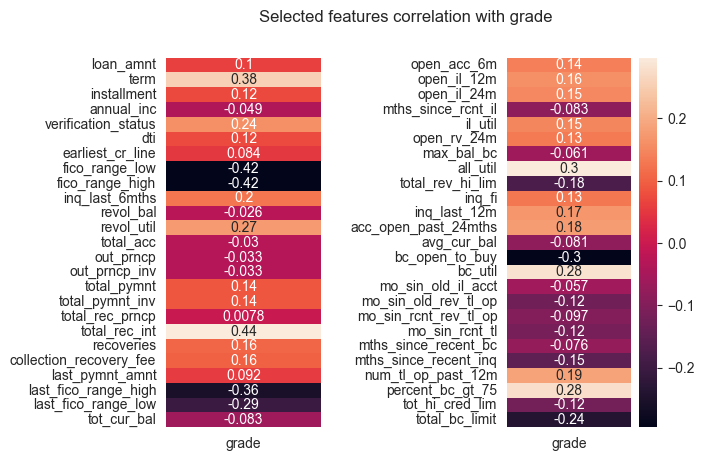

In [221]:
plt.subplot(1, 2, 1)
sns.heatmap(data=pd.DataFrame(selected_feats_corr_with_grade[:25]), annot=True, cbar="")
plt.subplot(1, 2, 2)
sns.heatmap(data=pd.DataFrame(selected_feats_corr_with_grade[25:-1]), annot=True)
plt.subplots_adjust(wspace=1.2)

plt.suptitle("Selected features correlation with grade")
plt.show()

📝 Correlation

Some features have strong correlation with grade such as fico_score related ones \
have correlation -0.3~ -0.4. 

But some have very weak correlations below 0.01.

This have shown that features with non-linear relationship with target were \
captured by Boruta.

---

📊 Prepare data for modeling

In [39]:
feat_selected_acc_df["purpose"] = feat_selected_acc_df.purpose.astype(
    "category")
feat_selected_acc_df["initial_list_status"] = (
    feat_selected_acc_df.initial_list_status.astype("category")
)

In [58]:
grade_pred_df = feat_selected_acc_df.copy()
grade_pred_df["grade"] = acc_df.grade.apply(lambda i: target_map[i])
grade_pred_df["sub_grade"] = acc_df.sub_grade.apply(lambda i: int(i[1]))
grade_pred_df["int_rate"] = acc_df.int_rate

grade_pred_df.head(3)

,loan_amnt,term,installment,annual_inc,verification_status,dti,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,...,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,purpose,initial_list_status,grade,sub_grade,int_rate
0,3600,0,123.03,55000.0,0,5.91,2003.0,675,679,1,...,4,3,0.0,178050,2400,debt_consolidation,w,2.0,4,13.99
1,24700,0,820.28,65000.0,0,16.06,1999.0,715,719,4,...,0,2,7.7,314017,79300,small_business,w,2.0,1,11.99
2,20000,1,432.66,63000.0,0,10.78,2000.0,695,699,0,...,10,0,50.0,218418,6200,home_improvement,w,1.0,4,10.78


In [59]:
joblib.dump(grade_pred_df, "data/grade_pred_df")

['data/grade_pred_df']

In [5]:
comp_df = comp_df.drop(columns=["zip_code"])
comp_df["loan_title"] = comp_df.loan_title.astype("category")
comp_df["state"] = comp_df.state.astype("category")

In [7]:
joblib.dump(comp_df, "data/loan_acc_pred_df")

['data/loan_acc_pred_df']